In [1]:
from huggingface_hub import login
from google.colab import userdata
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score
import warnings
import matplotlib.pyplot as plt
import spacy
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
hf_token = userdata.get('huggingface')
login(hf_token)

In [2]:
dataset_dim2 = load_dataset('Zlovoblachko/DeepSeek_dim2')

README.md:   0%|          | 0.00/543 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/102k [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1567 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/196 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/196 [00:00<?, ? examples/s]

In [3]:
train_df = pd.DataFrame(dataset_dim2['train'])
dev_df = pd.DataFrame(dataset_dim2['dev'])
test_df = pd.DataFrame(dataset_dim2['test'])

In [4]:
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {dev_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nClass distribution in train:\n{train_df['Label'].value_counts()}")

Train shape: (1567, 3)
Validation shape: (196, 3)
Test shape: (196, 3)

Class distribution in train:
Label
L    800
H    767
Name: count, dtype: int64


In [5]:
X_train_text = train_df['Sentence']
y_train = train_df['Label']
X_val_text = dev_df['Sentence']
y_val = dev_df['Label']
X_test_text = test_df['Sentence']
y_test = test_df['Label']

print(f"Sample combined text:\n{X_train_text.iloc[0][:200]}...")

Sample combined text:
So it will be possible for you to monitise your expertize on an sport market....


In [6]:
count_vectorizer = CountVectorizer(max_features=5000, min_df=2, max_df=0.95)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.95)

In [ ]:
X_train_count = count_vectorizer.fit_transform(X_train_text)
X_val_count = count_vectorizer.transform(X_val_text)
X_test_count = count_vectorizer.transform(X_test_text)

In [ ]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

In [ ]:
print(f"CountVectorizer shape: {X_train_count.shape}")
print(f"TF-IDF shape: {X_train_tfidf.shape}")

CountVectorizer shape: (1567, 1282)
TF-IDF shape: (1567, 1282)


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'n_estimators': [100, 200],
            'subsample': [0.8, 1.0]
        }
    }
}

vectorizers = {
    'CountVectorizer': (X_train_count, X_val_count, X_test_count),
    'TF-IDF': (X_train_tfidf, X_val_tfidf, X_test_tfidf)
}

In [ ]:
results = {}

for vec_name, (X_tr, X_v, X_te) in vectorizers.items():
    print(f"\n{'='*60}")
    print(f"Vectorizer: {vec_name}")
    print(f"{'='*60}")

    for model_name, model_config in models.items():
        print(f"\nTraining {model_name}...")
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,  # 5-fold cross-validation
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0,
            return_train_score=True
        )
        # Fit on training data
        grid_search.fit(X_tr, y_train_encoded)
        # Best model from grid search
        best_model = grid_search.best_estimator_
        # Cross-validation scores for reliability
        cv_results = cross_validate(
            best_model, X_tr, y_train_encoded,
            cv=5,
            scoring=['accuracy', 'f1_weighted'],
            return_train_score=True,
            n_jobs=-1
        )

        # Store results
        key = f"{vec_name}_{model_name}"
        results[key] = {
            'best_params': grid_search.best_params_,
            'best_model': best_model,
            'cv_scores': cv_results,
            'X_val': X_v,
            'X_test': X_te
        }

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"CV F1 Score: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std():.4f})")
        print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")


Vectorizer: CountVectorizer

Training Logistic Regression...
Best parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.5861 (+/- 0.0243)
CV Accuracy: 0.5865 (+/- 0.0246)

Training Decision Tree...
Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV F1 Score: 0.5523 (+/- 0.0339)
CV Accuracy: 0.5584 (+/- 0.0348)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
CV F1 Score: 0.5958 (+/- 0.0202)
CV Accuracy: 0.5961 (+/- 0.0201)

Vectorizer: TF-IDF

Training Logistic Regression...
Best parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.5931 (+/- 0.0116)
CV Accuracy: 0.5948 (+/- 0.0107)

Training Decision Tree...
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
CV F1 Score: 0.5454 (+/- 0.0238)
CV Accuracy: 0.5462 (+/- 0.0236)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators'

In [ ]:
print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE")
print("="*80)

for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Predict on validation set
    y_val_pred = res['best_model'].predict(res['X_val'])
    print(classification_report(y_val_encoded, y_val_pred, digits=4))

    # Cross-validation reliability statistics
    print(f"Cross-Validation Reliability:")
    print(f"  Accuracy: {res['cv_scores']['test_accuracy'].mean():.4f} (std: {res['cv_scores']['test_accuracy'].std():.4f})")
    print(f"  F1-Score: {res['cv_scores']['test_f1_weighted'].mean():.4f} (std: {res['cv_scores']['test_f1_weighted'].std():.4f})")

print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)

for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Predict on test set
    y_test_pred = res['best_model'].predict(res['X_test'])
    print(classification_report(y_test_encoded, y_test_pred, digits=4))


VALIDATION SET PERFORMANCE

CountVectorizer_Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5446    0.5729    0.5584        96
           1     0.5684    0.5400    0.5538       100

    accuracy                         0.5561       196
   macro avg     0.5565    0.5565    0.5561       196
weighted avg     0.5567    0.5561    0.5561       196

Cross-Validation Reliability:
  Accuracy: 0.5865 (std: 0.0246)
  F1-Score: 0.5861 (std: 0.0243)

CountVectorizer_Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5379    0.7396    0.6228        96
           1     0.6094    0.3900    0.4756       100

    accuracy                         0.5612       196
   macro avg     0.5736    0.5648    0.5492       196
weighted avg     0.5744    0.5612    0.5477       196

Cross-Validation Reliability:
  


CountVectorizer:
------------------------------------------------------------


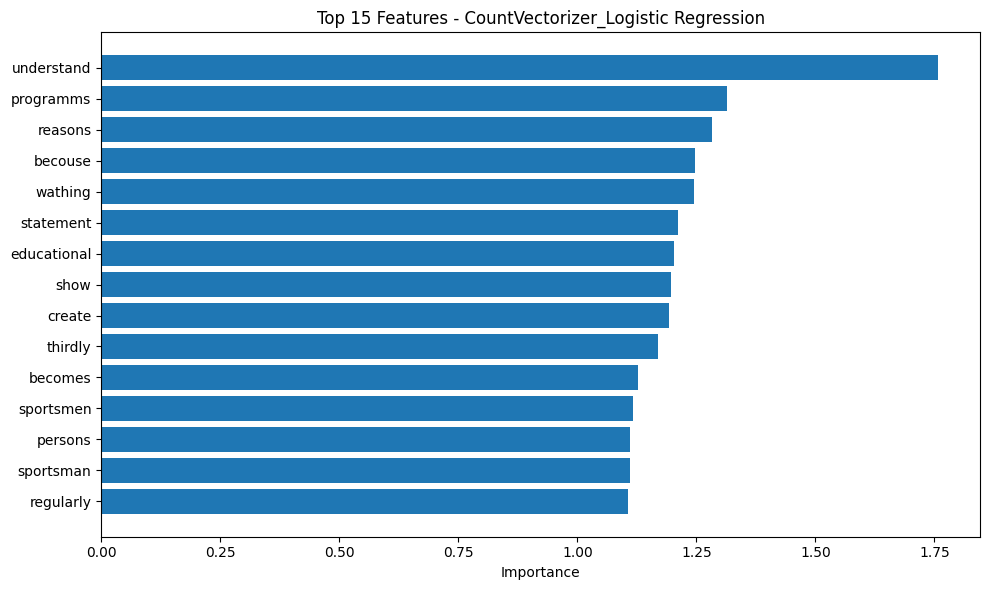


Logistic Regression - Top 10 features:
  thirdly: 1.1689
  create: 1.1924
  show: 1.1958
  educational: 1.2028
  statement: 1.2109
  wathing: 1.2459
  becouse: 1.2466
  reasons: 1.2828
  programms: 1.3139
  understand: 1.7579


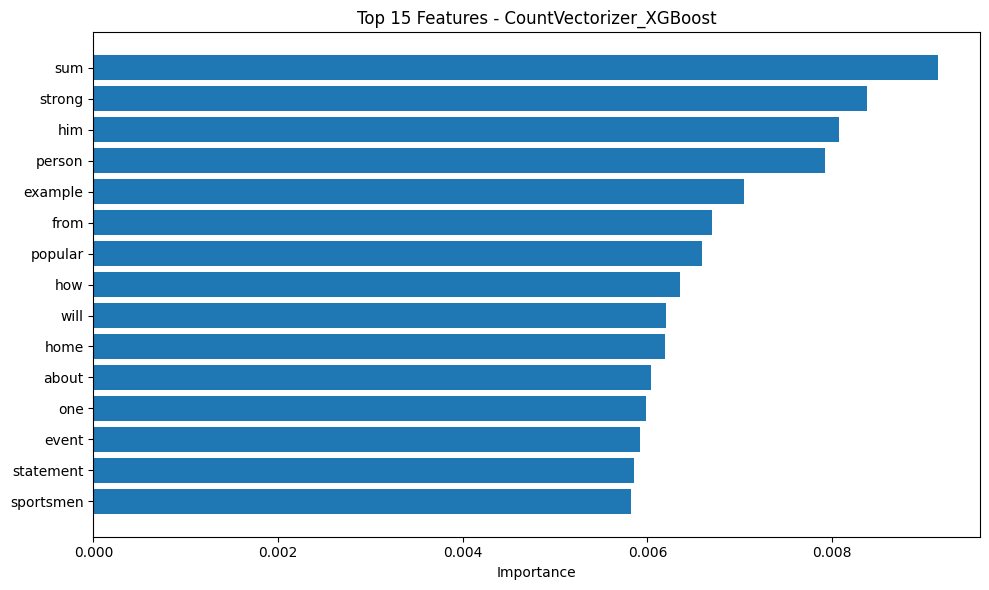


XGBoost - Top 10 features:
  home: 0.0062
  will: 0.0062
  how: 0.0064
  popular: 0.0066
  from: 0.0067
  example: 0.0070
  person: 0.0079
  him: 0.0081
  strong: 0.0084
  sum: 0.0091

TF-IDF:
------------------------------------------------------------


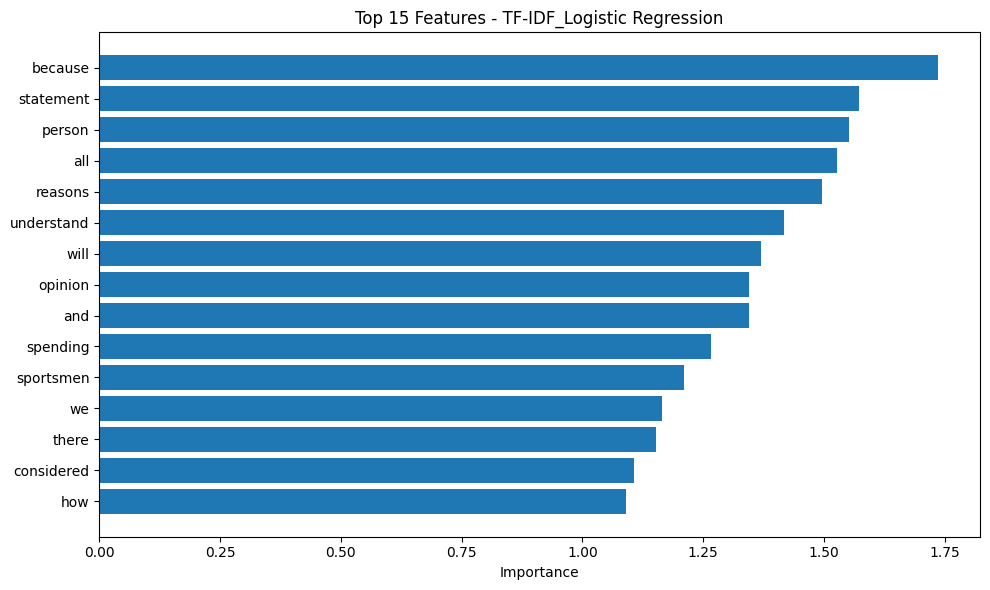


Logistic Regression - Top 10 features:
  spending: 1.2659
  and: 1.3453
  opinion: 1.3456
  will: 1.3703
  understand: 1.4178
  reasons: 1.4959
  all: 1.5270
  person: 1.5507
  statement: 1.5717
  because: 1.7359


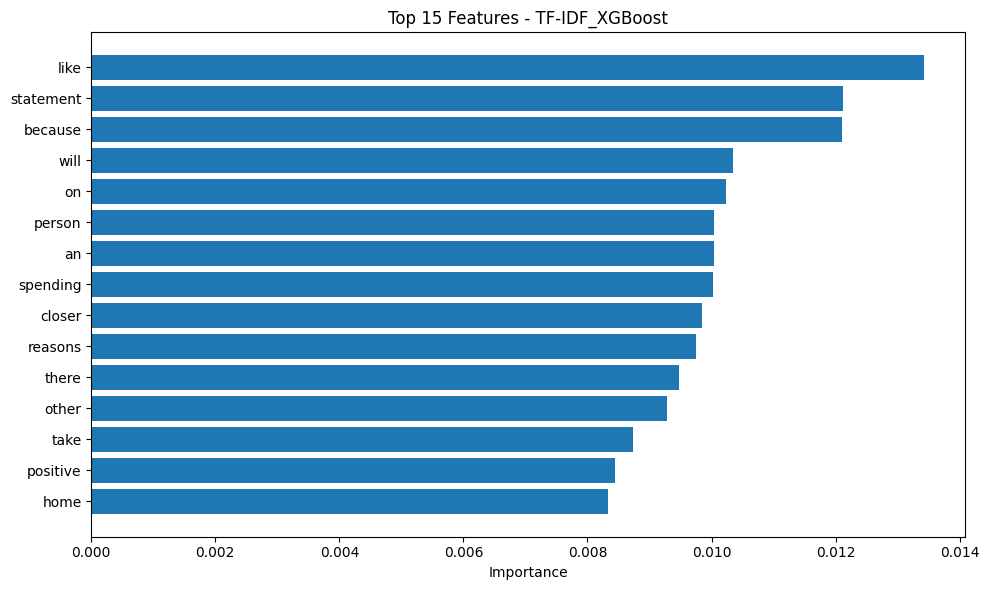


XGBoost - Top 10 features:
  reasons: 0.0097
  closer: 0.0098
  spending: 0.0100
  an: 0.0100
  person: 0.0100
  on: 0.0102
  will: 0.0104
  because: 0.0121
  statement: 0.0121
  like: 0.0134


In [ ]:
for vec_name, (X_tr, X_v, X_te) in vectorizers.items():
    vectorizer = count_vectorizer if vec_name == 'CountVectorizer' else tfidf_vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    print(f"\n{vec_name}:")
    print("-" * 60)

    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{vec_name}_{model_name}"
        model = results[key]['best_model']

        # Extract feature importance
        if hasattr(model, 'coef_'):  # Logistic Regression
            importance = np.abs(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):  # Tree-based models
            importance = model.feature_importances_
        else:
            continue

        # Top 15 features
        top_indices = np.argsort(importance)[-15:]
        top_features = feature_names[top_indices]
        top_importance = importance[top_indices]

        # Plot
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(top_features)), top_importance)
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Importance')
        plt.title(f'Top 15 Features - {key}')
        plt.tight_layout()
        plt.show()

        print(f"\n{model_name} - Top 10 features:")
        for feat, imp in zip(top_features[-10:], top_importance[-10:]):
            print(f"  {feat}: {imp:.4f}")

In [ ]:
summary_data = []

for key, res in results.items():
    y_val_pred = res['best_model'].predict(res['X_val'])
    y_test_pred = res['best_model'].predict(res['X_test'])

    summary_data.append({
        'Configuration': key,
        'CV_Accuracy_Mean': res['cv_scores']['test_accuracy'].mean(),
        'CV_Accuracy_Std': res['cv_scores']['test_accuracy'].std(),
        'CV_F1_Mean': res['cv_scores']['test_f1_weighted'].mean(),
        'CV_F1_Std': res['cv_scores']['test_f1_weighted'].std(),
        'Val_Accuracy': accuracy_score(y_val_encoded, y_val_pred),
        'Val_F1': f1_score(y_val_encoded, y_val_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_test_encoded, y_test_pred),
        'Test_F1': f1_score(y_test_encoded, y_test_pred, average='weighted')
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
print("\n" + "="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)
print(summary_df.to_string(index=False))


SUMMARY COMPARISON TABLE
                      Configuration  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std  Val_Accuracy  Val_F1  Test_Accuracy  Test_F1
CountVectorizer_Logistic Regression            0.5865           0.0246      0.5861     0.0243        0.5561  0.5561         0.5918   0.5908
      CountVectorizer_Decision Tree            0.5584           0.0348      0.5523     0.0339        0.5612  0.5477         0.5255   0.5017
            CountVectorizer_XGBoost            0.5961           0.0201      0.5958     0.0202        0.5714  0.5711         0.6429   0.6429
         TF-IDF_Logistic Regression            0.5948           0.0107      0.5931     0.0116        0.6224  0.6219         0.5918   0.5918
               TF-IDF_Decision Tree            0.5462           0.0236      0.5454     0.0238        0.5153  0.5138         0.5000   0.4992
                     TF-IDF_XGBoost            0.6024           0.0203      0.6020     0.0204        0.5459  0.5445         0.5969   0

Add preprocessing

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def preprocess_text(text):
    """Tokenize, lowercase, and lemmatize text using spaCy"""
    if pd.isna(text) or text == '':
        return ''

    # Process text with spaCy
    doc = nlp(text.lower())

    # Lemmatize and keep only alphabetic tokens
    lemmatized = [token.lemma_ for token in doc if token.is_alpha]

    return ' '.join(lemmatized)

In [ ]:
text_columns = ['Sentence']

print("Preprocessing training data...")
for col in text_columns:
    train_df[col] = train_df[col].apply(preprocess_text)

print("Preprocessing validation data...")
for col in text_columns:
    dev_df[col] = dev_df[col].apply(preprocess_text)

print("Preprocessing test data...")
for col in text_columns:
    test_df[col] = test_df[col].apply(preprocess_text)

print("\nSample preprocessed text:")
print(f"{train_df['Sentence'].iloc[0][:200]}...")

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...

Sample preprocessed text:
so it will be possible for you to monitise your expertize on an sport market...


In [ ]:
X_train = train_df[text_columns]
X_val = dev_df[text_columns]
X_test = test_df[text_columns]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1567, 1)
X_val shape: (196, 1)
X_test shape: (196, 1)


In [ ]:
count_transformer = ColumnTransformer(
    transformers=[
        ('sentence', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Sentence')
    ],
    remainder='drop',
    sparse_threshold=1.0
)

In [ ]:
tfidf_transformer = ColumnTransformer(
    transformers=[
        ('sentence', TfidfVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Sentence')
    ],
    remainder='drop',
    sparse_threshold=1.0
)

In [ ]:
print("Fitting CountVectorizer...")
X_train_count = count_transformer.fit_transform(X_train)
X_val_count = count_transformer.transform(X_val)
X_test_count = count_transformer.transform(X_test)

print("Fitting TF-IDF...")
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_val_tfidf = tfidf_transformer.transform(X_val)
X_test_tfidf = tfidf_transformer.transform(X_test)

print(f"\nCountVectorizer shape: {X_train_count.shape}")
print(f"TF-IDF shape: {X_train_tfidf.shape}")

Fitting CountVectorizer...
Fitting TF-IDF...

CountVectorizer shape: (1567, 1073)
TF-IDF shape: (1567, 1073)


In [ ]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'n_estimators': [100, 200],
            'subsample': [0.8, 1.0]
        }
    }
}

vectorizers = {
    'CountVectorizer': (X_train_count, X_val_count, X_test_count, count_transformer),
    'TF-IDF': (X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_transformer)
}

In [ ]:
results = {}

for vec_name, (X_tr, X_v, X_te, transformer) in vectorizers.items():
    print(f"\n{'='*60}")
    print(f"Vectorizer: {vec_name}")
    print(f"{'='*60}")

    for model_name, model_config in models.items():
        print(f"\nTraining {model_name}...")

        # Use encoded labels for XGBoost, original for others
        y_tr = y_train_encoded if model_name == 'XGBoost' else y_train

        # GridSearchCV with validation set scoring
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0,
            return_train_score=True
        )

        # Fit on training data
        grid_search.fit(X_tr, y_tr)

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Cross-validation scores for reliability
        cv_results = cross_validate(
            best_model, X_tr, y_tr,
            cv=5,
            scoring=['accuracy', 'f1_weighted'],
            return_train_score=True,
            n_jobs=-1
        )

        # Store results
        key = f"{vec_name}_{model_name}"
        results[key] = {
            'best_params': grid_search.best_params_,
            'best_model': best_model,
            'cv_scores': cv_results,
            'X_val': X_v,
            'X_test': X_te,
            'is_xgboost': model_name == 'XGBoost',
            'transformer': transformer
        }

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"CV F1 Score: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std():.4f})")
        print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")


Vectorizer: CountVectorizer

Training Logistic Regression...
Best parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.5876 (+/- 0.0274)
CV Accuracy: 0.5877 (+/- 0.0274)

Training Decision Tree...
Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
CV F1 Score: 0.5518 (+/- 0.0261)
CV Accuracy: 0.5526 (+/- 0.0255)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
CV F1 Score: 0.5845 (+/- 0.0219)
CV Accuracy: 0.5845 (+/- 0.0219)

Vectorizer: TF-IDF

Training Logistic Regression...
Best parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.5825 (+/- 0.0190)
CV Accuracy: 0.5826 (+/- 0.0190)

Training Decision Tree...
Best parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10}
CV F1 Score: 0.5411 (+/- 0.0215)
CV Accuracy: 0.5450 (+/- 0.0235)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimator

In [ ]:
for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_val_pred = res['best_model'].predict(res['X_val'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)
        print(classification_report(y_val, y_val_pred_decoded, digits=4))
    else:
        print(classification_report(y_val, y_val_pred, digits=4))

    # Cross-validation reliability statistics
    print(f"Cross-Validation Reliability:")
    print(f"  Accuracy: {res['cv_scores']['test_accuracy'].mean():.4f} (std: {res['cv_scores']['test_accuracy'].std():.4f})")
    print(f"  F1-Score: {res['cv_scores']['test_f1_weighted'].mean():.4f} (std: {res['cv_scores']['test_f1_weighted'].std():.4f})")

print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)

for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
        print(classification_report(y_test, y_test_pred_decoded, digits=4))
    else:
        print(classification_report(y_test, y_test_pred, digits=4))


CountVectorizer_Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           H     0.5464    0.5521    0.5492        96
           L     0.5657    0.5600    0.5628       100

    accuracy                         0.5561       196
   macro avg     0.5560    0.5560    0.5560       196
weighted avg     0.5562    0.5561    0.5562       196

Cross-Validation Reliability:
  Accuracy: 0.5877 (std: 0.0274)
  F1-Score: 0.5876 (std: 0.0274)

CountVectorizer_Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           H     0.5263    0.5208    0.5236        96
           L     0.5446    0.5500    0.5473       100

    accuracy                         0.5357       196
   macro avg     0.5354    0.5354    0.5354       196
weighted avg     0.5356    0.5357    0.5357       196

Cross-Validation Reliability:
  Accuracy: 0.5526 (std: 0.025

In [ ]:
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("TOP FEATURES PER COLUMN")
print("="*80)

for vec_name, (X_tr, X_v, X_te, transformer) in vectorizers.items():
    print(f"\n{vec_name}:")
    print("-" * 60)

    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{vec_name}_{model_name}"
        model = results[key]['best_model']

        # Extract feature importance
        if hasattr(model, 'coef_'):
            importance = np.abs(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        else:
            continue

        print(f"\n{model_name} - Top features per column:")

        # Get feature names for each column transformer
        feature_start = 0
        for col_name, vectorizer, col in transformer.transformers_:
            n_features = len(vectorizer.get_feature_names_out())
            col_importance = importance[feature_start:feature_start + n_features]
            col_features = vectorizer.get_feature_names_out()

            # Top 5 features for this column
            top_indices = np.argsort(col_importance)[-5:]
            top_features = col_features[top_indices]
            top_values = col_importance[top_indices]

            print(f"\n  {col}:")
            for feat, val in zip(reversed(top_features), reversed(top_values)):
                print(f"    {feat}: {val:.4f}")

            feature_start += n_features


TOP FEATURES PER COLUMN

CountVectorizer:
------------------------------------------------------------

Logistic Regression - Top features per column:

  Sentence:
    sportsman: 1.5756
    understand: 1.5357
    programms: 1.4921
    cause: 1.4032
    evening: 1.3532

XGBoost - Top features per column:

  Sentence:
    when: 0.0088
    person: 0.0078
    place: 0.0078
    big: 0.0068
    sportsman: 0.0060

TF-IDF:
------------------------------------------------------------

Logistic Regression - Top features per column:

  Sentence:
    sportsman: 5.6691
    understand: 4.9045
    because: 4.7125
    programms: 4.6905
    person: 4.5192

XGBoost - Top features per column:

  Sentence:
    person: 0.0159
    waste: 0.0140
    statement: 0.0138
    there: 0.0137
    on: 0.0131


In [ ]:
summary_data = []

for key, res in results.items():
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_t = y_test_encoded if res['is_xgboost'] else y_test

    y_val_pred = res['best_model'].predict(res['X_val'])
    y_test_pred = res['best_model'].predict(res['X_test'])

    summary_data.append({
        'Configuration': key,
        'CV_Accuracy_Mean': res['cv_scores']['test_accuracy'].mean(),
        'CV_Accuracy_Std': res['cv_scores']['test_accuracy'].std(),
        'CV_F1_Mean': res['cv_scores']['test_f1_weighted'].mean(),
        'CV_F1_Std': res['cv_scores']['test_f1_weighted'].std(),
        'Val_Accuracy': accuracy_score(y_v, y_val_pred),
        'Val_F1': f1_score(y_v, y_val_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_t, y_test_pred),
        'Test_F1': f1_score(y_t, y_test_pred, average='weighted')
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
print("\n" + "="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)
print(summary_df.to_string(index=False))


SUMMARY COMPARISON TABLE
                      Configuration  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std  Val_Accuracy  Val_F1  Test_Accuracy  Test_F1
CountVectorizer_Logistic Regression            0.5877           0.0274      0.5876     0.0274        0.5561  0.5562         0.5969   0.5957
      CountVectorizer_Decision Tree            0.5526           0.0255      0.5518     0.0261        0.5357  0.5357         0.5306   0.5283
            CountVectorizer_XGBoost            0.5845           0.0219      0.5845     0.0219        0.5714  0.5714         0.6224   0.6224
         TF-IDF_Logistic Regression            0.5826           0.0190      0.5825     0.0190        0.5357  0.5358         0.6020   0.6019
               TF-IDF_Decision Tree            0.5450           0.0235      0.5411     0.0215        0.5459  0.5454         0.5102   0.5015
                     TF-IDF_XGBoost            0.5954           0.0320      0.5950     0.0317        0.5714  0.5708         0.5663   0

In [ ]:
import pickle
import json
from datetime import datetime

# Find the best model based on test F1 score
best_config = None
best_f1 = 0
best_key = None

for key, res in results.items():
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])
    test_f1 = f1_score(y_t, y_test_pred, average='weighted')

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_key = key
        best_config = res

print("="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\nBest configuration: {best_key}")
print(f"Test F1 Score: {best_f1:.4f}")
print(f"Best hyperparameters: {best_config['best_params']}")

# Prepare the complete pipeline components
model_package = {
    'model': best_config['best_model'],
    'transformer': best_config['transformer'],
    'label_encoder': label_encoder,
    'text_columns': text_columns,
    'is_xgboost': best_config['is_xgboost'],
    'config_name': best_key,
    'best_params': best_config['best_params'],
    'performance': {
        'test_f1': best_f1,
        'test_accuracy': accuracy_score(
            y_test_encoded if best_config['is_xgboost'] else y_test,
            best_config['best_model'].predict(best_config['X_test'])
        ),
        'cv_f1_mean': best_config['cv_scores']['test_f1_weighted'].mean(),
        'cv_f1_std': best_config['cv_scores']['test_f1_weighted'].std(),
        'cv_accuracy_mean': best_config['cv_scores']['test_accuracy'].mean(),
        'cv_accuracy_std': best_config['cv_scores']['test_accuracy'].std()
    },
    'preprocessing_info': {
        'tokenization': 'spacy en_core_web_sm',
        'lowercasing': True,
        'lemmatization': True
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save the model package
model_filename = f'best_model_{best_key.replace(" ", "_")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"\nModel saved to: {model_filename}")
print(f"Package includes: model, transformer, label encoder, and metadata")

# Save metadata separately as JSON for easy inspection
metadata = {
    'config_name': best_key,
    'best_params': best_config['best_params'],
    'performance': model_package['performance'],
    'preprocessing_info': model_package['preprocessing_info'],
    'text_columns': text_columns,
    'timestamp': model_package['timestamp']
}

metadata_filename = f'best_model_{best_key.replace(" ", "_")}_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata saved to: {metadata_filename}")

BEST MODEL SELECTION

Best configuration: CountVectorizer_XGBoost
Test F1 Score: 0.6224
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

Model saved to: best_model_CountVectorizer_XGBoost.pkl
Package includes: model, transformer, label encoder, and metadata
Metadata saved to: best_model_CountVectorizer_XGBoost_metadata.json


In [ ]:
# Cell 14: Create a reusable prediction function and save it
def create_predictor(model_package):
    """
    Create a prediction function from the saved model package.
    This function can be used in a separate pipeline.
    """
    import spacy
    import pandas as pd

    # Load spacy if not already loaded
    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except:
        import subprocess
        subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    def preprocess_text(text):
        """Tokenize, lowercase, and lemmatize text"""
        if pd.isna(text) or text == '':
            return ''
        doc = nlp(text.lower())
        lemmatized = [token.lemma_ for token in doc if token.is_alpha]
        return ' '.join(lemmatized)

    def predict(data):
        """
        Predict labels for new data.

        Parameters:
        -----------
        data : dict or pd.DataFrame
            Must contain keys/columns: 'Thesis', 'Target sentence segment',
            'Last argument', 'Target sentence'

        Returns:
        --------
        predictions : array
            Predicted labels in original format ('H' or 'L')
        probabilities : array (if available)
            Prediction probabilities
        """
        # Convert to DataFrame if dict
        if isinstance(data, dict):
            df = pd.DataFrame([data])
        else:
            df = data.copy()

        # Preprocess text columns
        for col in model_package['text_columns']:
            df[col] = df[col].apply(preprocess_text)

        # Transform using saved transformer
        X_transformed = model_package['transformer'].transform(df[model_package['text_columns']])

        # Predict
        predictions_encoded = model_package['model'].predict(X_transformed)

        # Decode if XGBoost
        if model_package['is_xgboost']:
            predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
        else:
            predictions = predictions_encoded

        # Get probabilities if available
        probabilities = None
        if hasattr(model_package['model'], 'predict_proba'):
            probabilities = model_package['model'].predict_proba(X_transformed)

        return predictions, probabilities

    return predict

# Test the predictor with a sample
predictor = create_predictor(model_package)

# Test with first row from test set
test_sample = test_df[text_columns].iloc[0:1].copy()
# Reset to original (non-preprocessed) text for realistic test
# In real usage, you'd have raw text, so we simulate that here
print("\n" + "="*80)
print("TESTING SAVED MODEL")
print("="*80)
print("\nTest sample shape:", test_sample.shape)

predictions, probabilities = predictor(test_sample)

print(f"\nPrediction: {predictions[0]}")
print(f"True label: {test_df['Label'].iloc[0]}")
if probabilities is not None:
    print(f"Probabilities: {probabilities[0]}")

print("\n✓ Model package is working correctly!")


TESTING SAVED MODEL

Test sample shape: (1, 1)

Prediction: H
True label: L
Probabilities: [0.51084185 0.48915812]

✓ Model package is working correctly!


In [ ]:
# Cell 15: Save the predictor function as a standalone module
predictor_code = '''"""
Standalone predictor for the trained text classification model.
Load this module and use predict() function for inference.

Usage:
------
import pickle
from predictor import load_model_and_predict

# Load model
with open('best_model_XXX.pkl', 'rb') as f:
    model_package = pickle.load(f)

# Make predictions
data = {
    'Thesis': 'Your thesis text here',
    'Target sentence segment': 'Your segment text here',
    'Last argument': 'Your argument text here',
    'Target sentence': 'Your target sentence here'
}

predictions, probabilities = load_model_and_predict(model_package, data)
"""

import spacy
import pandas as pd

def preprocess_text(text, nlp):
    """Tokenize, lowercase, and lemmatize text"""
    if pd.isna(text) or text == '':
        return ''
    doc = nlp(text.lower())
    lemmatized = [token.lemma_ for token in doc if token.is_alpha]
    return ' '.join(lemmatized)

def load_model_and_predict(model_package, data):
    """
    Predict labels for new data using the saved model package.

    Parameters:
    -----------
    model_package : dict
        The loaded model package from pickle file
    data : dict or pd.DataFrame
        Must contain keys/columns: 'Thesis', 'Target sentence segment',
        'Last argument', 'Target sentence'

    Returns:
    --------
    predictions : array
        Predicted labels in original format ('H' or 'L')
    probabilities : array or None
        Prediction probabilities (if available)
    """
    # Load spacy
    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except:
        raise RuntimeError("Please install spacy model: python -m spacy download en_core_web_sm")

    # Convert to DataFrame if dict
    if isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = data.copy()

    # Preprocess text columns
    for col in model_package['text_columns']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
        df[col] = df[col].apply(lambda x: preprocess_text(x, nlp))

    # Transform using saved transformer
    X_transformed = model_package['transformer'].transform(df[model_package['text_columns']])

    # Predict
    predictions_encoded = model_package['model'].predict(X_transformed)

    # Decode if XGBoost
    if model_package['is_xgboost']:
        predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
    else:
        predictions = predictions_encoded

    # Get probabilities if available
    probabilities = None
    if hasattr(model_package['model'], 'predict_proba'):
        probabilities = model_package['model'].predict_proba(X_transformed)

    return predictions, probabilities
'''

# Save predictor as a Python module
with open('predictor.py', 'w') as f:
    f.write(predictor_code)

print("="*80)
print("PREDICTOR MODULE SAVED")
print("="*80)
print("\nSaved files:")
print(f"  1. {model_filename} - Complete model package")
print(f"  2. {metadata_filename} - Model metadata (JSON)")
print(f"  3. predictor.py - Standalone prediction module")
print("\nTo use in a new pipeline:")
print("  import pickle")
print("  from predictor import load_model_and_predict")
print(f"  ")
print(f"  with open('{model_filename}', 'rb') as f:")
print(f"      model_package = pickle.load(f)")
print(f"  ")
print(f"  predictions, probs = load_model_and_predict(model_package, your_data)")

PREDICTOR MODULE SAVED

Saved files:
  1. best_model_CountVectorizer_XGBoost.pkl - Complete model package
  2. best_model_CountVectorizer_XGBoost_metadata.json - Model metadata (JSON)
  3. predictor.py - Standalone prediction module

To use in a new pipeline:
  import pickle
  from predictor import load_model_and_predict
  
  with open('best_model_CountVectorizer_XGBoost.pkl', 'rb') as f:
      model_package = pickle.load(f)
  
  predictions, probs = load_model_and_predict(model_package, your_data)


## Embedding models

In [ ]:
!pip install sentence-transformers torch transformers

import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.preprocessing import normalize

In [ ]:
embedding_models = {
    'e5-base-v2': 'intfloat/e5-base-v2',
    'bge-small-en-v1.5': 'BAAI/bge-small-en-v1.5',
    'llama-small': 'meta-llama/Llama-3.2-1B'
}

def get_e5_embeddings(texts, model_name='intfloat/e5-base-v2'):
    """Get embeddings from E5 model"""
    model = SentenceTransformer(model_name)
    # E5 models require "query: " prefix for queries
    texts_with_prefix = [f"query: {text}" for text in texts]
    embeddings = model.encode(texts_with_prefix, show_progress_bar=True, batch_size=32)
    return embeddings

def get_bge_embeddings(texts, model_name='BAAI/bge-small-en-v1.5'):
    """Get embeddings from BGE model"""
    model = SentenceTransformer(model_name)
    # BGE models benefit from instruction prefix
    instruction = "Represent this sentence for classification: "
    texts_with_instruction = [instruction + text for text in texts]
    embeddings = model.encode(texts_with_instruction, show_progress_bar=True, batch_size=32)
    return embeddings

def get_llama_embeddings(texts, model_name='meta-llama/Llama-3.2-1B'):
    """Get embeddings from Llama model using mean pooling"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, torch_dtype=torch.float16)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    embeddings = []
    batch_size = 8  # Smaller batch for larger model

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize
        encoded = tokenizer(batch_texts, padding=True, truncation=True,
                           max_length=512, return_tensors='pt')
        encoded = {k: v.to(device) for k, v in encoded.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = model(**encoded)
            # Mean pooling
            attention_mask = encoded['attention_mask']
            token_embeddings = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            embeddings.append(batch_embeddings)

        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + len(batch_texts)}/{len(texts)} texts")

    return np.vstack(embeddings)

print("Embedding functions defined")
print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Embedding functions defined
Using device: cuda


In [ ]:
text_columns = ['Sentence']

In [ ]:
X_train_raw = train_df[text_columns]
X_val_raw = dev_df[text_columns]
X_test_raw = test_df[text_columns]

print(f"X_train_raw shape: {X_train_raw.shape}")
print(f"X_val_raw shape: {X_val_raw.shape}")
print(f"X_test_raw shape: {X_test_raw.shape}")

X_train_raw shape: (1567, 1)
X_val_raw shape: (196, 1)
X_test_raw shape: (196, 1)


In [ ]:
print("\n" + "="*80)
print("GENERATING E5-BASE-V2 EMBEDDINGS (PER COLUMN)")
print("="*80)

model_e5 = SentenceTransformer('intfloat/e5-base-v2')

# Generate embeddings for each column separately
X_train_e5_cols = []
X_val_e5_cols = []
X_test_e5_cols = []

for col in text_columns:
    print(f"\nProcessing column: {col}")

    # Training set
    print("  Training set...")
    texts_train = X_train_raw[col].fillna('').apply(lambda x: f"query: {x}").tolist()
    emb_train = model_e5.encode(texts_train, show_progress_bar=True, batch_size=32)
    X_train_e5_cols.append(emb_train)

    # Validation set
    print("  Validation set...")
    texts_val = X_val_raw[col].fillna('').apply(lambda x: f"query: {x}").tolist()
    emb_val = model_e5.encode(texts_val, show_progress_bar=True, batch_size=32)
    X_val_e5_cols.append(emb_val)

    # Test set
    print("  Test set...")
    texts_test = X_test_raw[col].fillna('').apply(lambda x: f"query: {x}").tolist()
    emb_test = model_e5.encode(texts_test, show_progress_bar=True, batch_size=32)
    X_test_e5_cols.append(emb_test)

# Concatenate all column embeddings
X_train_e5 = np.hstack(X_train_e5_cols)
X_val_e5 = np.hstack(X_val_e5_cols)
X_test_e5 = np.hstack(X_test_e5_cols)

print(f"\nE5 embeddings shape: {X_train_e5.shape}")
print(f"(Each of {len(text_columns)} columns contributes {X_train_e5_cols[0].shape[1]} dimensions)")


GENERATING E5-BASE-V2 EMBEDDINGS (PER COLUMN)

Processing column: Sentence
  Training set...


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]


E5 embeddings shape: (1567, 768)
(Each of 1 columns contributes 768 dimensions)


In [ ]:
# Cell 21: Generate embeddings for BGE-small-en-v1.5 using ColumnTransformer approach
print("\n" + "="*80)
print("GENERATING BGE-SMALL-EN-V1.5 EMBEDDINGS (PER COLUMN)")
print("="*80)

model_bge = SentenceTransformer('BAAI/bge-small-en-v1.5')
instruction = "Represent this sentence for classification: "

# Generate embeddings for each column separately
X_train_bge_cols = []
X_val_bge_cols = []
X_test_bge_cols = []

for col in text_columns:
    print(f"\nProcessing column: {col}")

    # Training set
    print("  Training set...")
    texts_train = X_train_raw[col].fillna('').apply(lambda x: instruction + x).tolist()
    emb_train = model_bge.encode(texts_train, show_progress_bar=True, batch_size=32)
    X_train_bge_cols.append(emb_train)

    # Validation set
    print("  Validation set...")
    texts_val = X_val_raw[col].fillna('').apply(lambda x: instruction + x).tolist()
    emb_val = model_bge.encode(texts_val, show_progress_bar=True, batch_size=32)
    X_val_bge_cols.append(emb_val)

    # Test set
    print("  Test set...")
    texts_test = X_test_raw[col].fillna('').apply(lambda x: instruction + x).tolist()
    emb_test = model_bge.encode(texts_test, show_progress_bar=True, batch_size=32)
    X_test_bge_cols.append(emb_test)

# Concatenate all column embeddings
X_train_bge = np.hstack(X_train_bge_cols)
X_val_bge = np.hstack(X_val_bge_cols)
X_test_bge = np.hstack(X_test_bge_cols)

print(f"\nBGE embeddings shape: {X_train_bge.shape}")
print(f"(Each of {len(text_columns)} columns contributes {X_train_bge_cols[0].shape[1]} dimensions)")


GENERATING BGE-SMALL-EN-V1.5 EMBEDDINGS (PER COLUMN)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Processing column: Sentence
  Training set...


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]


BGE embeddings shape: (1567, 384)
(Each of 1 columns contributes 384 dimensions)


In [ ]:
# Cell 22: Generate embeddings for Llama using ColumnTransformer approach (OPTIONAL)
print("\n" + "="*80)
print("GENERATING LLAMA EMBEDDINGS (PER COLUMN)")
print("="*80)
print("WARNING: This may take a while and requires significant memory")

try:
    tokenizer = AutoTokenizer.from_pretrained('keeeeenw/MicroLlama-text-embedding')
    model_llama = AutoModel.from_pretrained('keeeeenw/MicroLlama-text-embedding', torch_dtype=torch.float16)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_llama = model_llama.to(device)
    model_llama.eval()

    def get_llama_embeddings_batch(texts, batch_size=8):
        """Helper function for batched Llama embeddings"""
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded = tokenizer(batch_texts, padding=True, truncation=True,
                               max_length=512, return_tensors='pt')
            encoded = {k: v.to(device) for k, v in encoded.items()}

            with torch.no_grad():
                outputs = model_llama(**encoded)
                attention_mask = encoded['attention_mask']
                token_embeddings = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
                embeddings.append(batch_embeddings)

            if (i // batch_size + 1) % 10 == 0:
                print(f"    Processed {i + len(batch_texts)}/{len(texts)} texts")

        return np.vstack(embeddings)

    # Generate embeddings for each column separately
    X_train_llama_cols = []
    X_val_llama_cols = []
    X_test_llama_cols = []

    for col in text_columns:
        print(f"\nProcessing column: {col}")

        # Training set
        print("  Training set...")
        texts_train = X_train_raw[col].fillna('').tolist()
        emb_train = get_llama_embeddings_batch(texts_train)
        X_train_llama_cols.append(emb_train)

        # Validation set
        print("  Validation set...")
        texts_val = X_val_raw[col].fillna('').tolist()
        emb_val = get_llama_embeddings_batch(texts_val)
        X_val_llama_cols.append(emb_val)

        # Test set
        print("  Test set...")
        texts_test = X_test_raw[col].fillna('').tolist()
        emb_test = get_llama_embeddings_batch(texts_test)
        X_test_llama_cols.append(emb_test)

    # Concatenate all column embeddings
    X_train_llama = np.hstack(X_train_llama_cols)
    X_val_llama = np.hstack(X_val_llama_cols)
    X_test_llama = np.hstack(X_test_llama_cols)

    print(f"\nLlama embeddings shape: {X_train_llama.shape}")
    print(f"(Each of {len(text_columns)} columns contributes {X_train_llama_cols[0].shape[1]} dimensions)")
    llama_available = True

except Exception as e:
    print(f"\nFailed to generate Llama embeddings: {e}")
    print("Continuing with E5 and BGE only...")
    llama_available = False


GENERATING LLAMA EMBEDDINGS (PER COLUMN)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]


Processing column: Sentence
  Training set...
    Processed 80/1567 texts
    Processed 160/1567 texts
    Processed 240/1567 texts
    Processed 320/1567 texts
    Processed 400/1567 texts
    Processed 480/1567 texts
    Processed 560/1567 texts
    Processed 640/1567 texts
    Processed 720/1567 texts
    Processed 800/1567 texts
    Processed 880/1567 texts
    Processed 960/1567 texts
    Processed 1040/1567 texts
    Processed 1120/1567 texts
    Processed 1200/1567 texts
    Processed 1280/1567 texts
    Processed 1360/1567 texts
    Processed 1440/1567 texts
    Processed 1520/1567 texts
  Validation set...
    Processed 80/196 texts
    Processed 160/196 texts
  Test set...
    Processed 80/196 texts
    Processed 160/196 texts

Llama embeddings shape: (1567, 1024)
(Each of 1 columns contributes 1024 dimensions)


In [ ]:
embedding_vectorizers = {
    'E5-base-v2': (X_train_e5, X_val_e5, X_test_e5),
    'BGE-small-en-v1.5': (X_train_bge, X_val_bge, X_test_bge)
}

if llama_available:
    embedding_vectorizers['Llama'] = (X_train_llama, X_val_llama, X_test_llama)

print(f"\nAvailable embeddings: {list(embedding_vectorizers.keys())}")


Available embeddings: ['E5-base-v2', 'BGE-small-en-v1.5', 'Llama']


In [ ]:
# Cell 7: Define models and hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100],
            'subsample': [0.8, 1.0]
        }
    }
}

In [ ]:
# Cell 24: Train models with embeddings
embedding_results = {}

for emb_name, (X_tr, X_v, X_te) in embedding_vectorizers.items():
    print(f"\n{'='*60}")
    print(f"Embedding Model: {emb_name}")
    print(f"{'='*60}")

    for model_name, model_config in models.items():
        print(f"\nTraining {model_name}...")

        # Use encoded labels for XGBoost, original for others
        y_tr = y_train_encoded if model_name == 'XGBoost' else y_train

        # GridSearchCV with validation set scoring
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0,
            return_train_score=True
        )

        # Fit on training data
        grid_search.fit(X_tr, y_tr)

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Cross-validation scores for reliability
        cv_results = cross_validate(
            best_model, X_tr, y_tr,
            cv=5,
            scoring=['accuracy', 'f1_weighted'],
            return_train_score=True,
            n_jobs=-1
        )

        # Store results
        key = f"{emb_name}_{model_name}"
        embedding_results[key] = {
            'best_params': grid_search.best_params_,
            'best_model': best_model,
            'cv_scores': cv_results,
            'X_val': X_v,
            'X_test': X_te,
            'is_xgboost': model_name == 'XGBoost',
            'embedding_name': emb_name
        }

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"CV F1 Score: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std():.4f})")
        print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")


Embedding Model: E5-base-v2

Training Logistic Regression...
Best parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.6865 (+/- 0.0349)
CV Accuracy: 0.6867 (+/- 0.0350)

Training Decision Tree...
Best parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10}
CV F1 Score: 0.5786 (+/- 0.0227)
CV Accuracy: 0.5788 (+/- 0.0225)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
CV F1 Score: 0.6546 (+/- 0.0146)
CV Accuracy: 0.6548 (+/- 0.0146)

Embedding Model: BGE-small-en-v1.5

Training Logistic Regression...
Best parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.6247 (+/- 0.0193)
CV Accuracy: 0.6248 (+/- 0.0193)

Training Decision Tree...
Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
CV F1 Score: 0.5457 (+/- 0.0278)
CV Accuracy: 0.5463 (+/- 0.0276)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 

In [ ]:
# Cell 25: Evaluate embedding-based models
print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE (EMBEDDINGS)")
print("="*80)

for key, res in embedding_results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_val_pred = res['best_model'].predict(res['X_val'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)
        print(classification_report(y_val, y_val_pred_decoded, digits=4))
    else:
        print(classification_report(y_val, y_val_pred, digits=4))

    # Cross-validation reliability statistics
    print(f"Cross-Validation Reliability:")
    print(f"  Accuracy: {res['cv_scores']['test_accuracy'].mean():.4f} (std: {res['cv_scores']['test_accuracy'].std():.4f})")
    print(f"  F1-Score: {res['cv_scores']['test_f1_weighted'].mean():.4f} (std: {res['cv_scores']['test_f1_weighted'].std():.4f})")

print("\n" + "="*80)
print("TEST SET PERFORMANCE (EMBEDDINGS)")
print("="*80)

for key, res in embedding_results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
        print(classification_report(y_test, y_test_pred_decoded, digits=4))
    else:
        print(classification_report(y_test, y_test_pred, digits=4))


VALIDATION SET PERFORMANCE (EMBEDDINGS)

E5-base-v2_Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           H     0.7129    0.7500    0.7310        96
           L     0.7474    0.7100    0.7282       100

    accuracy                         0.7296       196
   macro avg     0.7301    0.7300    0.7296       196
weighted avg     0.7305    0.7296    0.7296       196

Cross-Validation Reliability:
  Accuracy: 0.6867 (std: 0.0350)
  F1-Score: 0.6865 (std: 0.0349)

E5-base-v2_Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           H     0.5426    0.5312    0.5368        96
           L     0.5588    0.5700    0.5644       100

    accuracy                         0.5510       196
   macro avg     0.5507    0.5506    0.5506       196
weighted avg     0.5509    0.5510    0.5509       196

Cross-Validation Reliability:

In [ ]:
# Cell 26: Embedding results summary table
embedding_summary_data = []

for key, res in embedding_results.items():
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_t = y_test_encoded if res['is_xgboost'] else y_test

    y_val_pred = res['best_model'].predict(res['X_val'])
    y_test_pred = res['best_model'].predict(res['X_test'])

    embedding_summary_data.append({
        'Configuration': key,
        'CV_Accuracy_Mean': res['cv_scores']['test_accuracy'].mean(),
        'CV_Accuracy_Std': res['cv_scores']['test_accuracy'].std(),
        'CV_F1_Mean': res['cv_scores']['test_f1_weighted'].mean(),
        'CV_F1_Std': res['cv_scores']['test_f1_weighted'].std(),
        'Val_Accuracy': accuracy_score(y_v, y_val_pred),
        'Val_F1': f1_score(y_v, y_val_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_t, y_test_pred),
        'Test_F1': f1_score(y_t, y_test_pred, average='weighted')
    })

embedding_summary_df = pd.DataFrame(embedding_summary_data)
embedding_summary_df = embedding_summary_df.round(4)
print("\n" + "="*80)
print("EMBEDDING MODELS SUMMARY")
print("="*80)
print(embedding_summary_df.to_string(index=False))


EMBEDDING MODELS SUMMARY
                        Configuration  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std  Val_Accuracy  Val_F1  Test_Accuracy  Test_F1
       E5-base-v2_Logistic Regression            0.6867           0.0350      0.6865     0.0349        0.7296  0.7296         0.6684   0.6683
             E5-base-v2_Decision Tree            0.5788           0.0225      0.5786     0.0227        0.5510  0.5509         0.5510   0.5510
                   E5-base-v2_XGBoost            0.6548           0.0146      0.6546     0.0146        0.6939  0.6938         0.6786   0.6782
BGE-small-en-v1.5_Logistic Regression            0.6248           0.0193      0.6247     0.0193        0.6786  0.6782         0.6429   0.6429
      BGE-small-en-v1.5_Decision Tree            0.5463           0.0276      0.5457     0.0278        0.5561  0.5552         0.5102   0.5103
            BGE-small-en-v1.5_XGBoost            0.6012           0.0164      0.6007     0.0165        0.6582  0.6582     

In [ ]:
# Cell 28: Identify and save the overall best model
import pickle
import json
from datetime import datetime

# Combine all results (traditional vectorizers + embeddings)
all_results = {**embedding_results}

# Find the best model based on test F1 score
best_config = None
best_f1 = 0
best_key = None
best_type = None  # 'traditional' or 'embedding'

print("="*80)
print("EVALUATING ALL MODELS")
print("="*80)

for key, res in all_results.items():
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])
    test_f1 = f1_score(y_t, y_test_pred, average='weighted')
    test_acc = accuracy_score(y_t, y_test_pred)

    print(f"{key:50s} - Test F1: {test_f1:.4f}, Test Acc: {test_acc:.4f}")

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_key = key
        best_config = res
        # Determine if it's traditional or embedding-based
        best_type = 'embedding' if 'embedding_name' in res else 'traditional'

print("\n" + "="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\nBest configuration: {best_key}")
print(f"Model type: {best_type}")
print(f"Test F1 Score: {best_f1:.4f}")
print(f"Best hyperparameters: {best_config['best_params']}")

# Calculate test accuracy for best model
y_t = y_test_encoded if best_config['is_xgboost'] else y_test
y_test_pred_best = best_config['best_model'].predict(best_config['X_test'])
test_accuracy = accuracy_score(y_t, y_test_pred_best)

# Prepare the complete pipeline components based on model type
# Embedding-based model
embedding_name = best_config['embedding_name']
model_package = {
        'model': best_config['best_model'],
        'label_encoder': label_encoder,
        'text_columns': text_columns,
        'is_xgboost': best_config['is_xgboost'],
        'config_name': best_key,
        'model_type': 'embedding',
        'embedding_name': embedding_name,
        'best_params': best_config['best_params'],
        'performance': {
            'test_f1': best_f1,
            'test_accuracy': test_accuracy,
            'cv_f1_mean': best_config['cv_scores']['test_f1_weighted'].mean(),
            'cv_f1_std': best_config['cv_scores']['test_f1_weighted'].std(),
            'cv_accuracy_mean': best_config['cv_scores']['test_accuracy'].mean(),
            'cv_accuracy_std': best_config['cv_scores']['test_accuracy'].std()
        },
        'preprocessing_info': {
            'preprocessing': 'none',
            'embedding_model': embedding_name,
            'per_column_embedding': True
        },
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

# Save the model package
model_filename = f'best_overall_model_{best_key.replace(" ", "_").replace("/", "-")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"\nModel saved to: {model_filename}")
print(f"Package includes: model, {'transformer, ' if best_type == 'traditional' else ''}label encoder, and metadata")

# Save metadata separately as JSON for easy inspection
metadata = {
    'config_name': best_key,
    'model_type': best_type,
    'best_params': best_config['best_params'],
    'performance': model_package['performance'],
    'preprocessing_info': model_package['preprocessing_info'],
    'text_columns': text_columns,
    'timestamp': model_package['timestamp']
}

metadata_filename = f'best_overall_model_{best_key.replace(" ", "_").replace("/", "-")}_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata saved to: {metadata_filename}")

EVALUATING ALL MODELS
E5-base-v2_Logistic Regression                     - Test F1: 0.6683, Test Acc: 0.6684
E5-base-v2_Decision Tree                           - Test F1: 0.5510, Test Acc: 0.5510
E5-base-v2_XGBoost                                 - Test F1: 0.6782, Test Acc: 0.6786
BGE-small-en-v1.5_Logistic Regression              - Test F1: 0.6429, Test Acc: 0.6429
BGE-small-en-v1.5_Decision Tree                    - Test F1: 0.5103, Test Acc: 0.5102
BGE-small-en-v1.5_XGBoost                          - Test F1: 0.6377, Test Acc: 0.6378
Llama_Logistic Regression                          - Test F1: 0.6784, Test Acc: 0.6786
Llama_Decision Tree                                - Test F1: 0.5101, Test Acc: 0.5102
Llama_XGBoost                                      - Test F1: 0.6727, Test Acc: 0.6735

BEST MODEL SELECTION

Best configuration: Llama_Logistic Regression
Model type: embedding
Test F1 Score: 0.6784
Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

Model saved 

In [ ]:
def create_embedding_predictor(model_package):
    """
    Create a prediction function for embedding-based models.
    """
    import pandas as pd
    import numpy as np
    import torch
    from sentence_transformers import SentenceTransformer
    from transformers import AutoTokenizer, AutoModel

    embedding_name = model_package['embedding_name']

    # Determine embedding model and configuration
    if 'E5' in embedding_name or 'e5' in embedding_name:
        emb_model = SentenceTransformer('intfloat/e5-base-v2')
        use_llama = False
        prefix = 'query: '
    elif 'BGE' in embedding_name or 'bge' in embedding_name:
        emb_model = SentenceTransformer('BAAI/bge-small-en-v1.5')
        use_llama = False
        prefix = 'Represent this sentence for classification: '
    elif 'Llama' in embedding_name or 'llama' in embedding_name:
        # Load Llama model and tokenizer
        tokenizer = AutoTokenizer.from_pretrained('keeeeenw/MicroLlama-text-embedding')
        emb_model = AutoModel.from_pretrained('keeeeenw/MicroLlama-text-embedding', torch_dtype=torch.float16)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        emb_model = emb_model.to(device)
        emb_model.eval()
        use_llama = True
        prefix = ''
    else:
        raise ValueError(f"Unknown embedding model: {embedding_name}")

    def get_llama_embeddings(texts, batch_size=8):
        """Generate Llama embeddings with mean pooling"""
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded = tokenizer(batch_texts, padding=True, truncation=True,
                               max_length=512, return_tensors='pt')
            encoded = {k: v.to(device) for k, v in encoded.items()}

            with torch.no_grad():
                outputs = emb_model(**encoded)
                attention_mask = encoded['attention_mask']
                token_embeddings = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
                embeddings.append(batch_embeddings)

        return np.vstack(embeddings)

    def predict(data):
        """Predict labels for new data"""
        if isinstance(data, dict):
            df = pd.DataFrame([data])
        else:
            df = data.copy()

        # Generate embeddings for each column
        embeddings_list = []
        for col in model_package['text_columns']:
            texts = df[col].fillna('').tolist()

            if use_llama:
                col_embeddings = get_llama_embeddings(texts)
            else:
                texts_with_prefix = [prefix + text for text in texts]
                col_embeddings = emb_model.encode(texts_with_prefix, show_progress_bar=False, batch_size=32)

            embeddings_list.append(col_embeddings)

        # Concatenate all column embeddings
        X_transformed = np.hstack(embeddings_list)

        # Predict
        predictions_encoded = model_package['model'].predict(X_transformed)

        # Decode if XGBoost
        if model_package['is_xgboost']:
            predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
        else:
            predictions = predictions_encoded

        # Get probabilities if available
        probabilities = None
        if hasattr(model_package['model'], 'predict_proba'):
            probabilities = model_package['model'].predict_proba(X_transformed)

        return predictions, probabilities

    return predict

predictor = create_embedding_predictor(model_package)

# Test the predictor with a sample
print("\n" + "="*80)
print("TESTING SAVED MODEL")
print("="*80)

# Use raw test data for realistic test
test_sample = test_df[text_columns].iloc[0:1].copy()

print("\nTest sample shape:", test_sample.shape)

predictions, probabilities = predictor(test_sample)

print(f"\nPrediction: {predictions[0]}")
print(f"True label: {test_df['Label'].iloc[1]}")
if probabilities is not None:
    print(f"Probabilities: {probabilities[0]}")

print("\n✓ Model package is working correctly!")


TESTING SAVED MODEL

Test sample shape: (1, 1)

Prediction: H
True label: H
Probabilities: [0.68995048 0.31004952]

✓ Model package is working correctly!


In [ ]:
# Cell 30: REPLACE - Save standalone predictor modules with full Llama support
traditional_predictor_code = '''"""
Standalone predictor for traditional vectorizer-based models.

Usage:
------
import pickle
from traditional_predictor import load_model_and_predict

with open('best_overall_model_XXX.pkl', 'rb') as f:
    model_package = pickle.load(f)

data = {
    'Thesis': 'Your thesis text here',
    'Target sentence segment': 'Your segment text here',
    'Last argument': 'Your argument text here',
    'Target sentence': 'Your target sentence here'
}

predictions, probabilities = load_model_and_predict(model_package, data)
"""

import spacy
import pandas as pd

def preprocess_text(text, nlp):
    """Tokenize, lowercase, and lemmatize text"""
    if pd.isna(text) or text == '':
        return ''
    doc = nlp(text.lower())
    lemmatized = [token.lemma_ for token in doc if token.is_alpha]
    return ' '.join(lemmatized)

def load_model_and_predict(model_package, data):
    """Predict labels using traditional vectorizer model"""
    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except:
        raise RuntimeError("Please install spacy model: python -m spacy download en_core_web_sm")

    if isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = data.copy()

    for col in model_package['text_columns']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
        df[col] = df[col].apply(lambda x: preprocess_text(x, nlp))

    X_transformed = model_package['transformer'].transform(df[model_package['text_columns']])
    predictions_encoded = model_package['model'].predict(X_transformed)

    if model_package['is_xgboost']:
        predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
    else:
        predictions = predictions_encoded

    probabilities = None
    if hasattr(model_package['model'], 'predict_proba'):
        probabilities = model_package['model'].predict_proba(X_transformed)

    return predictions, probabilities
'''

embedding_predictor_code = '''"""
Standalone predictor for embedding-based models.
Supports E5, BGE, and Llama embeddings.

Requirements:
------------
pip install sentence-transformers transformers torch

Usage:
------
import pickle
from embedding_predictor import load_model_and_predict

with open('best_overall_model_XXX.pkl', 'rb') as f:
    model_package = pickle.load(f)

data = {
    'Thesis': 'Your thesis text here',
    'Target sentence segment': 'Your segment text here',
    'Last argument': 'Your argument text here',
    'Target sentence': 'Your target sentence here'
}

predictions, probabilities = load_model_and_predict(model_package, data)
"""

import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

def get_llama_embeddings(texts, tokenizer, model, device, batch_size=8):
    """Generate Llama embeddings with mean pooling"""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts, padding=True, truncation=True,
                           max_length=512, return_tensors='pt')
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
            attention_mask = encoded['attention_mask']
            token_embeddings = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def load_model_and_predict(model_package, data):
    """Predict labels using embedding-based model"""
    embedding_name = model_package['embedding_name']

    # Load appropriate embedding model
    if 'E5' in embedding_name or 'e5' in embedding_name:
        emb_model = SentenceTransformer('intfloat/e5-base-v2')
        use_llama = False
        prefix = 'query: '

    elif 'BGE' in embedding_name or 'bge' in embedding_name:
        emb_model = SentenceTransformer('BAAI/bge-small-en-v1.5')
        use_llama = False
        prefix = 'Represent this sentence for classification: '

    elif 'Llama' in embedding_name or 'llama' in embedding_name:
        print("Loading Llama model (this may take a moment)...")
        tokenizer = AutoTokenizer.from_pretrained('keeeeenw/MicroLlama-text-embedding')
        emb_model = AutoModel.from_pretrained('keeeeenw/MicroLlama-text-embedding', torch_dtype=torch.float16)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        emb_model = emb_model.to(device)
        emb_model.eval()
        use_llama = True
        print(f"Llama model loaded on {device}")

    else:
        raise ValueError(f"Unsupported embedding model: {embedding_name}")

    if isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = data.copy()

    # Generate embeddings for each column
    embeddings_list = []
    for col in model_package['text_columns']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

        texts = df[col].fillna('').tolist()

        if use_llama:
            col_embeddings = get_llama_embeddings(texts, tokenizer, emb_model, device)
        else:
            texts_with_prefix = [prefix + text for text in texts]
            col_embeddings = emb_model.encode(texts_with_prefix, show_progress_bar=False, batch_size=32)

        embeddings_list.append(col_embeddings)

    # Concatenate all column embeddings
    X_transformed = np.hstack(embeddings_list)

    # Predict
    predictions_encoded = model_package['model'].predict(X_transformed)

    if model_package['is_xgboost']:
        predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
    else:
        predictions = predictions_encoded

    probabilities = None
    if hasattr(model_package['model'], 'predict_proba'):
        probabilities = model_package['model'].predict_proba(X_transformed)

    return predictions, probabilities
'''
predictor_filename = 'embedding_predictor.py'
with open(predictor_filename, 'w') as f:
    f.write(embedding_predictor_code)

print("\n" + "="*80)
print("PREDICTOR MODULE SAVED")
print("="*80)
print(f"\nSaved files:")
print(f"  1. {model_filename} - Complete model package")
print(f"  2. {metadata_filename} - Model metadata (JSON)")
print(f"  3. {predictor_filename} - Standalone prediction module")
print(f"\nModel Type: {best_type.upper()}")
if best_type == 'embedding':
    print(f"Embedding Model: {model_package['embedding_name']}")
    if 'Llama' in model_package['embedding_name']:
        print(f"\n⚠️  Note: Llama requires transformers and torch packages")
        print(f"   Installation: pip install transformers torch")
print(f"\nTo use in a new pipeline:")
print(f"  import pickle")
print(f"  from {predictor_filename[:-3]} import load_model_and_predict")
print(f"  ")
print(f"  with open('{model_filename}', 'rb') as f:")
print(f"      model_package = pickle.load(f)")
print(f"  ")
print(f"  predictions, probs = load_model_and_predict(model_package, your_data)")


PREDICTOR MODULE SAVED

Saved files:
  1. best_overall_model_Llama_Logistic_Regression.pkl - Complete model package
  2. best_overall_model_Llama_Logistic_Regression_metadata.json - Model metadata (JSON)
  3. embedding_predictor.py - Standalone prediction module

Model Type: EMBEDDING
Embedding Model: Llama

⚠️  Note: Llama requires transformers and torch packages
   Installation: pip install transformers torch

To use in a new pipeline:
  import pickle
  from embedding_predictor import load_model_and_predict
  
  with open('best_overall_model_Llama_Logistic_Regression.pkl', 'rb') as f:
      model_package = pickle.load(f)
  
  predictions, probs = load_model_and_predict(model_package, your_data)
